<a href="https://colab.research.google.com/github/MIlhamEr/Skripsi/blob/main/LSTM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [2]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1555.0,1555.0,1490.0,1495.0,835.632202,76612000
1,2020-01-03,1460.0,1470.0,1425.0,1465.0,856.372375,117795600
2,2020-01-06,1455.0,1515.0,1450.0,1465.0,856.372375,61423200
3,2020-01-07,1480.0,1540.0,1460.0,1540.0,900.213867,74336500
4,2020-01-08,1530.0,1535.0,1505.0,1505.0,879.754395,55121100


In [3]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [4]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,1360.0,1435.0,1360.0,1435.0,1435.0,5000
1,2020-01-03,1435.0,1435.0,1435.0,1435.0,1435.0,0
2,2020-01-06,1437.5,1437.5,1435.0,1435.0,1435.0,3000
3,2020-01-07,1435.0,1435.0,1435.0,1435.0,1435.0,0
4,2020-01-08,1435.0,1435.0,1435.0,1435.0,1435.0,0


In [5]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Cleaning Dataset

In [6]:
adro_missing = adro.isnull().sum()
dssa_missing = dssa.isnull().sum()

print("Missing values in ADRO:")
print(adro_missing)
print("\nMissing values in DSSA:")
print(dssa_missing)

Missing values in ADRO:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values in DSSA:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
print("Data duplicate in ADRO: ", adro.duplicated().sum())
print("Data duplicate in DSSA: ", dssa.duplicated().sum())

Data duplicate in ADRO:  0
Data duplicate in DSSA:  0


## Normalisasi Data

*   Normalisasi data pake MinMaxScaler
*   Kolom Date Ga dipake

In [8]:
scaler = MinMaxScaler()

In [9]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [10]:
adro_norm = adro.copy()
adro_norm = normalize_data(adro_norm)

In [11]:
dssa_norm = dssa.copy()
dssa_norm = normalize_data(dssa_norm)

## Prepare Data

Data look back yaitu adalah data yang biasanya dipakai untuk tipe time series, data ini menjadikan nilai lookback+1 sebagai nilai prediksi , dan data lookbacknya sebagai fitur.Ini berlaku untuk seluruh data, contoh penggambarannya seperti pada gambar diatas

In [12]:
def prepare_data(df, look_back):
    X, y = [], []
    for i in range(len(df)-look_back):
        t = []
        for j in range(look_back):
            t.append(df.iloc[i + j].values)  # Use all columns for features
        X.append(t)
        y.append(df['Close'][i + look_back]) # Predict Close price
    return np.array(X), np.array(y)

In [13]:
look_back = 30
X_adro, y_adro = prepare_data(adro_norm, look_back)

In [14]:
X_dssa, y_dssa = prepare_data(dssa_norm, look_back)

## Split data into training and testing sets

In [15]:
X_train_adro, X_test_adro, y_train_adro, y_test_adro = train_test_split(X_adro, y_adro, test_size=0.2, shuffle=False)
X_train_dssa, X_test_dssa, y_train_dssa, y_test_dssa = train_test_split(X_dssa, y_dssa, test_size=0.2, shuffle=False)

## Reshape data for LSTM (samples, timesteps, features)

In [16]:
X_train_adro = X_train_adro.reshape(X_train_adro.shape[0], look_back, X_train_adro.shape[2])
X_test_adro = X_test_adro.reshape(X_test_adro.shape[0], look_back, X_test_adro.shape[2])
X_train_dssa = X_train_dssa.reshape(X_train_dssa.shape[0], look_back, X_train_dssa.shape[2])
X_test_dssa = X_test_dssa.reshape(X_test_dssa.shape[0], look_back, X_test_dssa.shape[2])

# LSTM

In [17]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for single prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [18]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'R-squared: {r2:.5f}')
    return mae, mse, rmse, r2

## ADRO

In [19]:
input_shape_adro = (X_train_adro.shape[1], X_train_adro.shape[2])
model_adro = create_lstm_model(input_shape_adro)
model_adro.fit(X_train_adro, y_train_adro, epochs=50, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0863
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0077
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0064
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0041
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0037
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0045
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0043
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0036
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0036
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0034
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0033
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0031
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0033
Epoch 15/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0033
Epo

### Make predictions

In [20]:
y_pred_adro = model_adro.predict(X_test_adro)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


## DSSA

In [21]:
input_shape_dssa = (X_train_dssa.shape[1], X_train_dssa.shape[2])
model_dssa = create_lstm_model(input_shape_dssa)
model_dssa.fit(X_train_dssa, y_train_dssa, epochs=50, batch_size=32)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0015
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.4754e-05
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.9463e-05
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 7.8438e-05
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.5934e-05
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.2202e-05
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.5463e-05
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7473e-05
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.1158e-05
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.0025e-05
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.7470e-05
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.1376e-05
Epoch 13/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.4665e-05
Epoch 14/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.9891e-05
Epoch 15/50
28/28 ━

### Make predictions

In [22]:
y_pred_dssa = model_dssa.predict(X_test_dssa)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [23]:
# Evaluate ADRO model
print("Evaluation for ADRO:")
mae_adro, mse_adro, rmse_adro, r2_adro = evaluate_model(y_test_adro, y_pred_adro)

# Evaluate DSSA model
print("\nEvaluation for DSSA:")
mae_dssa, mse_dssa, rmse_dssa, r2_dssa = evaluate_model(y_test_dssa, y_pred_dssa)

Evaluation for ADRO:
MAE: 0.022
MSE: 0.001
RMSE: 0.029
R-squared: 0.92551

Evaluation for DSSA:
MAE: 0.092
MSE: 0.020
RMSE: 0.141
R-squared: 0.77434


## Plot the predicted vs actual values

In [24]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Price')
    plt.plot(y_pred, label='Predicted Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

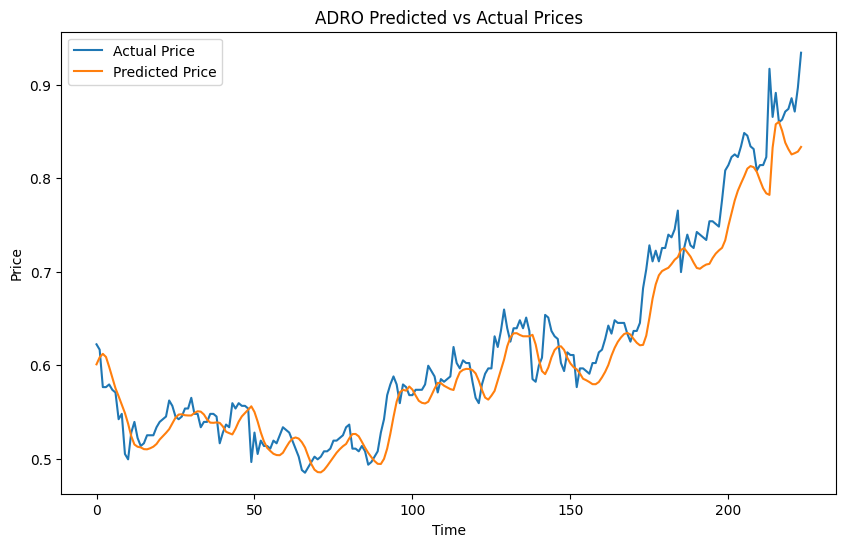

In [25]:
# Plot ADRO predictions
plot_predictions(y_test_adro, y_pred_adro, 'ADRO Predicted vs Actual Prices')

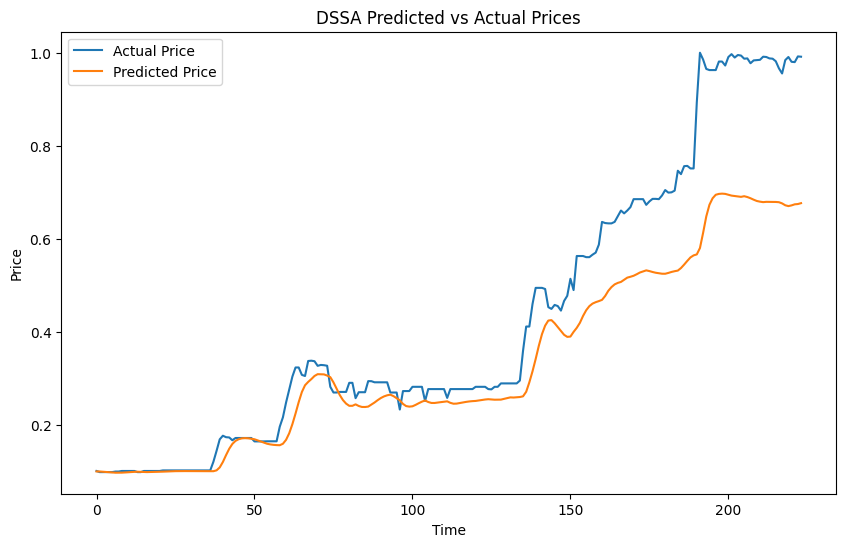

In [26]:
# Plot DSSA predictions
plot_predictions(y_test_dssa, y_pred_dssa, 'DSSA Predicted vs Actual Prices')